# Versão unificada

In [ ]:
import os


HOME = os.getcwd()
print("HOME:", HOME)
# instalação e configuração
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!pip install -q supervision jupyter_bbox_widget
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget https://filedn.com/lqyeLp7CcY45K7LkYnSUQdX/map/test.tif -P {HOME}/data


In [9]:
################# Script de processamento
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from tqdm import tqdm

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

# === 1. Carregar imagem com OpenCV ===
image_bgr = cv2.imread(f"{HOME}/data/test.tif")
height, width, _ = image_bgr.shape

# === 2. Parâmetros do tile ===
tile_size = 1024
annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# === 3. Criar imagem de saída (anotada) ===
final_annotated = np.zeros_like(image_bgr)


# === 4. Varredura por blocos ===
tile_size = 1024
centros_globais = []

for y0 in tqdm(range(0, height, tile_size), desc="Processando linhas"):
    for x0 in range(0, width, tile_size):
        y1 = min(y0 + tile_size, height)
        x1 = min(x0 + tile_size, width)

        tile_bgr = image_bgr[y0:y1, x0:x1]
        if tile_bgr.shape[0] < 64 or tile_bgr.shape[1] < 64:
            continue  # pula blocos pequenos

        # === Aplicar SAM ===
        tile_rgb = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2RGB)
        sam_result = mask_generator.generate(tile_rgb)

        # Parâmetro ajustável: porcentagem máxima de ocupação da tile por uma máscara
        max_area_ratio = 0.02

        # === Filtrar sam_result ===
        filtered_masks = [
            m for m in sam_result
            if m["segmentation"].sum() / m["segmentation"].size < max_area_ratio
        ]

        for m in filtered_masks:
          mask = m["segmentation"].astype(np.uint8)

          # Usar moments do OpenCV para calcular centroide local (dentro do tile)
          M = cv2.moments(mask)
          if M["m00"] == 0:
              continue  # evita divisão por zero

          cx_tile = int(M["m10"] / M["m00"])  # coluna local
          cy_tile = int(M["m01"] / M["m00"])  # linha local

          # Converter para coordenadas globais (na imagem original)
          cx_global = x0 + cx_tile
          cy_global = y0 + cy_tile

          centros_globais.append((cx_global, cy_global))

       # === Criar detections com máscaras filtradas ===
        detections = sv.Detections.from_sam(sam_result=filtered_masks)


        annotated_tile = annotator.annotate(scene=tile_bgr.copy(), detections=detections)

        # Reposicionar tile segmentado na imagem final
        final_annotated[y0:y1, x0:x1] = annotated_tile


import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import math

# 1. organiza pontos
pts = np.array(centros_globais)  # shape (N,2), col0=x, col1=y

# 2. encontra direção das fileiras via NN
nbrs = NearestNeighbors(n_neighbors=2).fit(pts)
_, idx = nbrs.kneighbors(pts)
neighbors = pts[idx[:,1]]  # pega o 2º vizinho (o 1º é o próprio ponto)

vectors = neighbors - pts
angles = np.arctan2(vectors[:,1], vectors[:,0])
# normaliza para [0, π)
angles = np.mod(angles, math.pi)

# histograma e pico
hist, bins = np.histogram(angles, bins=180, range=(0, math.pi))
theta = (bins[np.argmax(hist)] + bins[np.argmax(hist)+1]) / 2

# 3. rotaciona para alinhar horizontalmente
cos_t, sin_t = math.cos(-theta), math.sin(-theta)
R = np.array([[cos_t, -sin_t],
              [sin_t,  cos_t]])
pts_rot = pts.dot(R.T)

# 4. clusteriza pelas coordenadas y_rot
y_vals = pts_rot[:,1].reshape(-1,1)
# eps ajusta-se à distância inter-fileiras (em px)
db = DBSCAN(eps=20, min_samples=5).fit(y_vals)
labels = db.labels_

# 5. para cada fileira, calcula slope e intercept
slope = math.tan(theta)
linhas = []
for lbl in set(labels):
    if lbl < 0:
        continue  # ruído
    grp = pts[labels == lbl]
    xm, ym = grp.mean(axis=0)
    intercept = ym - slope * xm
    linhas.append((slope, intercept))

# linhas agora é uma lista de (m, b) para cada fileira: y = m·x + b
print(f"Detectei {len(linhas)} fileiras")
for i, (m, b) in enumerate(linhas):
    print(f"  Fileira {i+1}: y = {m:.4f}·x + {b:.1f}")



Processando linhas: 100%|██████████| 8/8 [05:32<00:00, 41.54s/it]


Detectei 39 fileiras
  Fileira 1: y = 0.0087·x + 1008.0
  Fileira 2: y = 0.0087·x + 757.6
  Fileira 3: y = 0.0087·x + 896.4
  Fileira 4: y = 0.0087·x + 239.8
  Fileira 5: y = 0.0087·x + 1663.8
  Fileira 6: y = 0.0087·x + 1994.2
  Fileira 7: y = 0.0087·x + 1399.8
  Fileira 8: y = 0.0087·x + 1770.5
  Fileira 9: y = 0.0087·x + 1197.8
  Fileira 10: y = 0.0087·x + 1534.5
  Fileira 11: y = 0.0087·x + 2350.8
  Fileira 12: y = 0.0087·x + 2207.2
  Fileira 13: y = 0.0087·x + 2535.5
  Fileira 14: y = 0.0087·x + 2942.5
  Fileira 15: y = 0.0087·x + 2679.5
  Fileira 16: y = 0.0087·x + 3059.2
  Fileira 17: y = 0.0087·x + 2854.0
  Fileira 18: y = 0.0087·x + 2785.2
  Fileira 19: y = 0.0087·x + 3257.3
  Fileira 20: y = 0.0087·x + 3941.9
  Fileira 21: y = 0.0087·x + 3770.8
  Fileira 22: y = 0.0087·x + 3655.0
  Fileira 23: y = 0.0087·x + 4097.1
  Fileira 24: y = 0.0087·x + 3821.2
  Fileira 25: y = 0.0087·x + 3567.9
  Fileira 26: y = 0.0087·x + 3438.9
  Fileira 27: y = 0.0087·x + 3499.9
  Fileira 28: y = 0

In [ ]:
import cv2
import numpy as np

# 1. Carrega a imagem original (BGR)
h, w = image_bgr.shape[:2]

# 2. Supondo que você já tenha:
#    centros_globais: lista de (x,y)
#    linhas:       lista de (m, b) para y = m*x + b

output = image_bgr.copy()

# 3. Desenha os centroides
for x, y in centros_globais:
    cv2.circle(output, (int(x), int(y)), radius=5, color=(0,0,255), thickness=-1)

# 4. Desenha cada reta, calculando dois pontos de interseção com as bordas
for m, b in linhas:
    pts = []
    # interseção com x=0
    y0 = b
    if 0 <= y0 <= h:
        pts.append((0, int(y0)))
    # interseção com x=w-1
    y1 = m*(w-1) + b
    if 0 <= y1 <= h:
        pts.append((w-1, int(y1)))
    # interseção com y=0 (se m != 0)
    if m != 0:
        x0 = -b/m
        if 0 <= x0 <= w:
            pts.append((int(x0), 0))
    # interseção com y=h-1
    if m != 0:
        x1 = (h-1 - b)/m
        if 0 <= x1 <= w:
            pts.append((int(x1), h-1))
    # Se temos pelo menos dois pontos válidos, desenha o segmento
    if len(pts) >= 2:
        cv2.line(output, pts[0], pts[1], color=(0,255,0), thickness=2)

# 5. Salva em disco
cv2.imwrite(f"{HOME}/data/imagem_com_centroides_e_fileiras.png", output)

# Teste exploratório

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

In [ ]:
!pip install -q supervision jupyter_bbox_widget

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [8]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

NameError: name 'SAM2AutomaticMaskGenerator' is not defined

In [ ]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg" # Changed to an existing image file

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Download de arquivos
Obtém a ortofoto e o DSM


In [ ]:
!wget https://filedn.com/lqyeLp7CcY45K7LkYnSUQdX/map/Task-of-2025-07-14T185032197Z-orthophoto.tif -P {HOME}/data
!wget https://filedn.com/lqyeLp7CcY45K7LkYnSUQdX/map/Task-of-2025-07-14T185032197Z-dsm.tif -P {HOME}/data



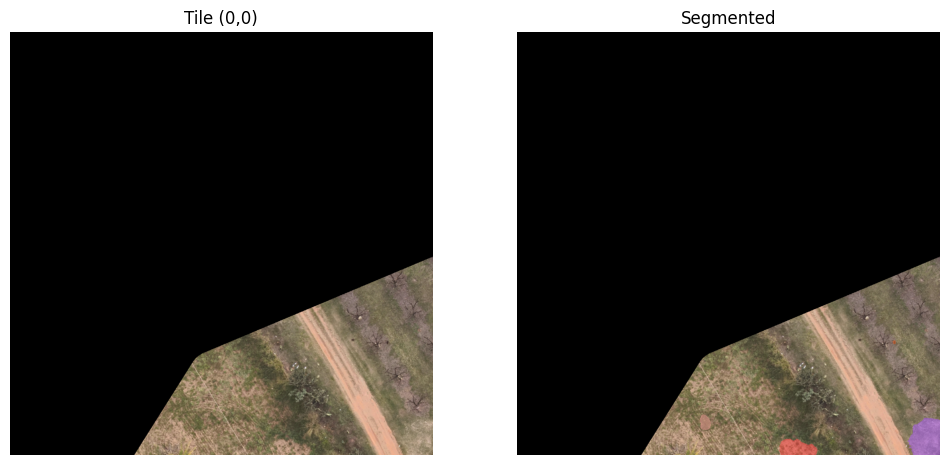

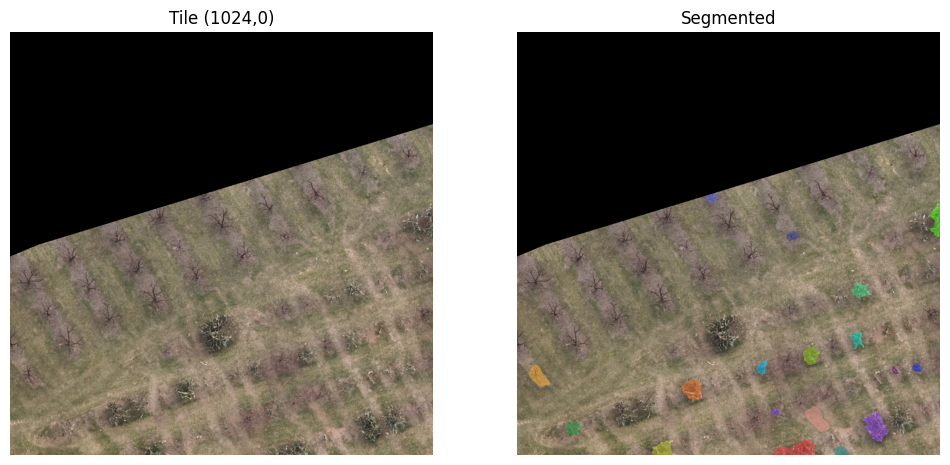

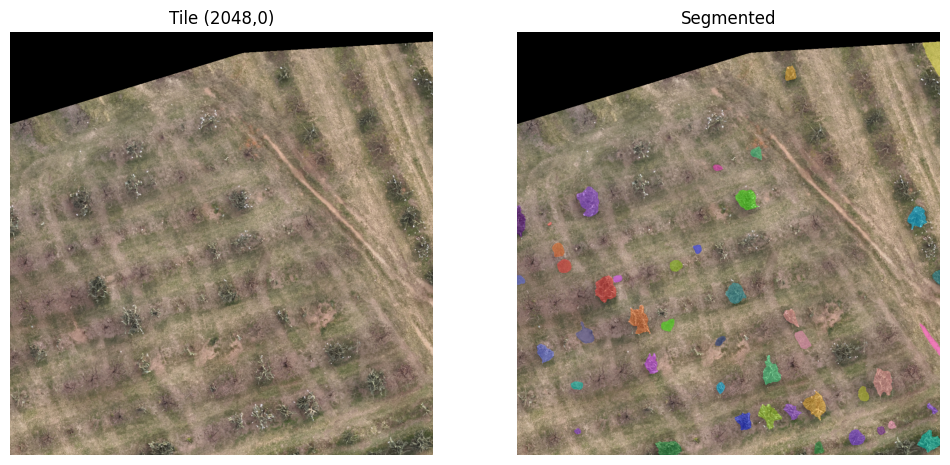

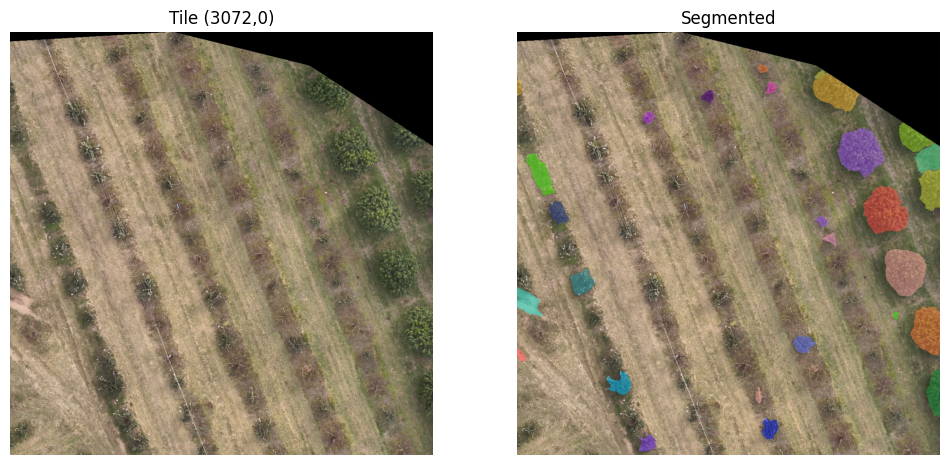

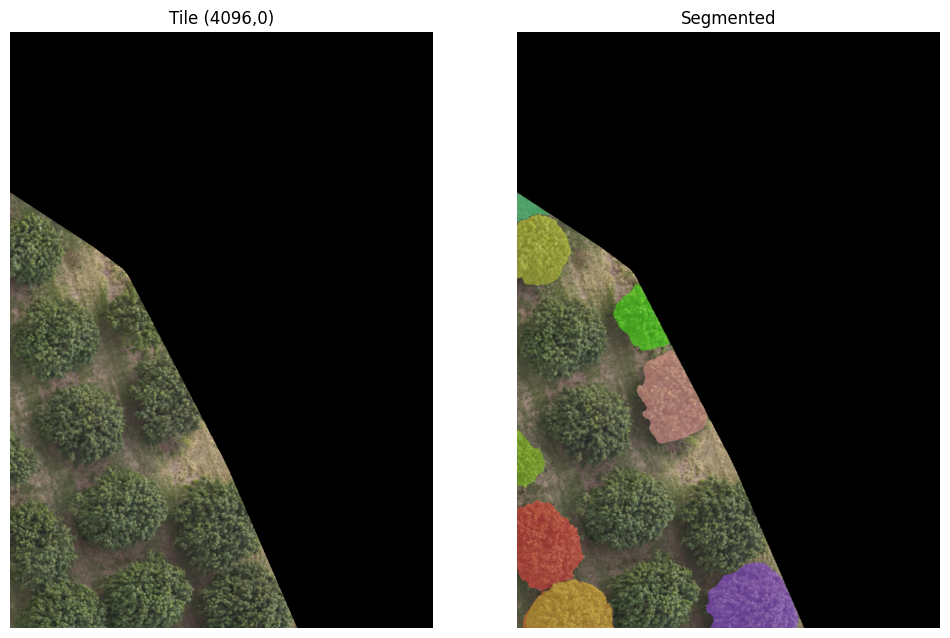

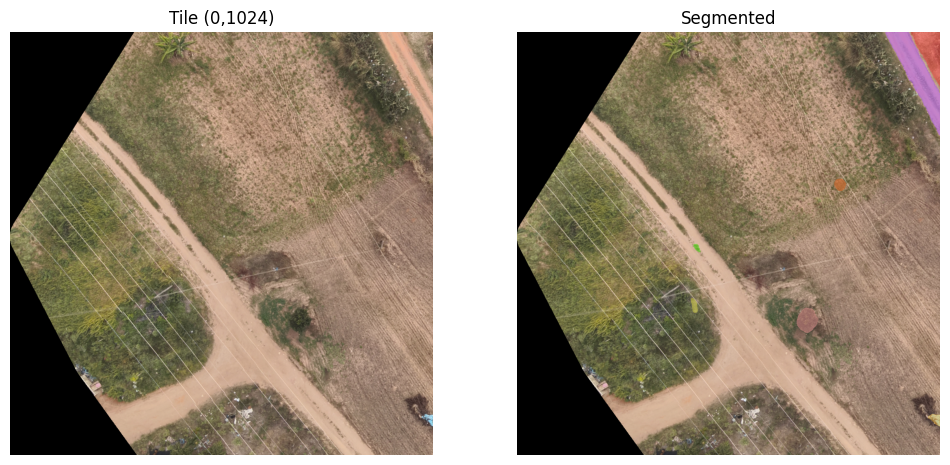

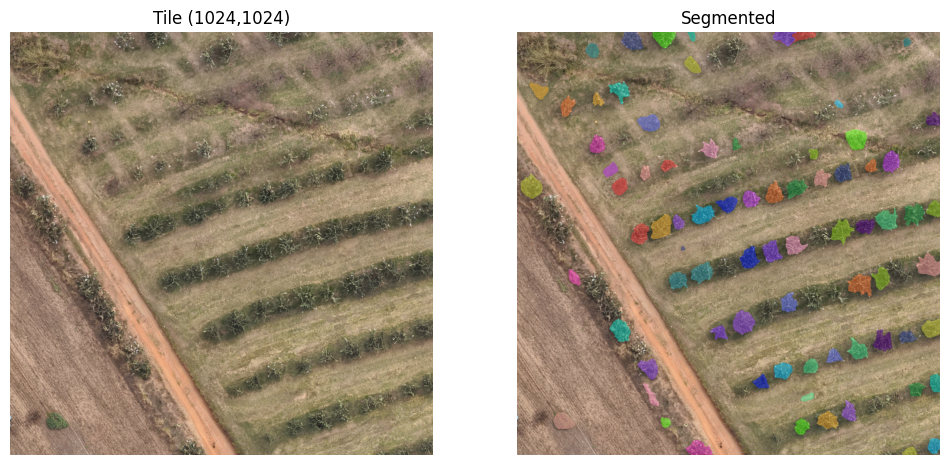

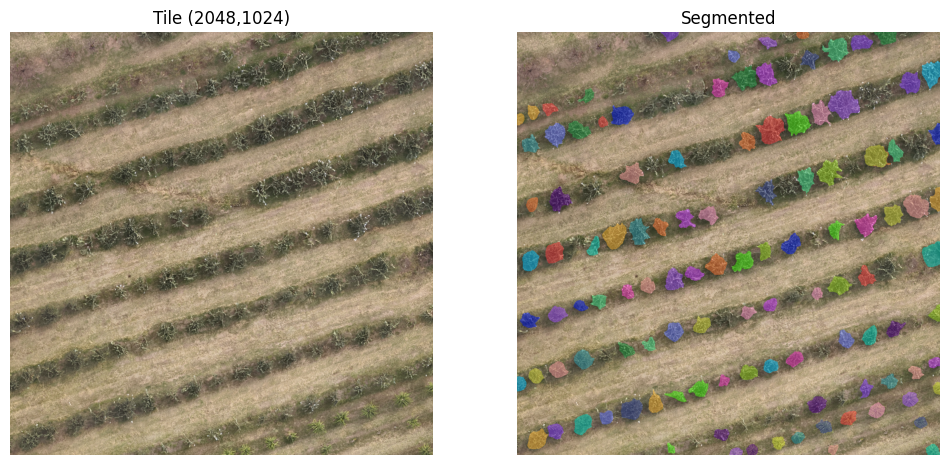

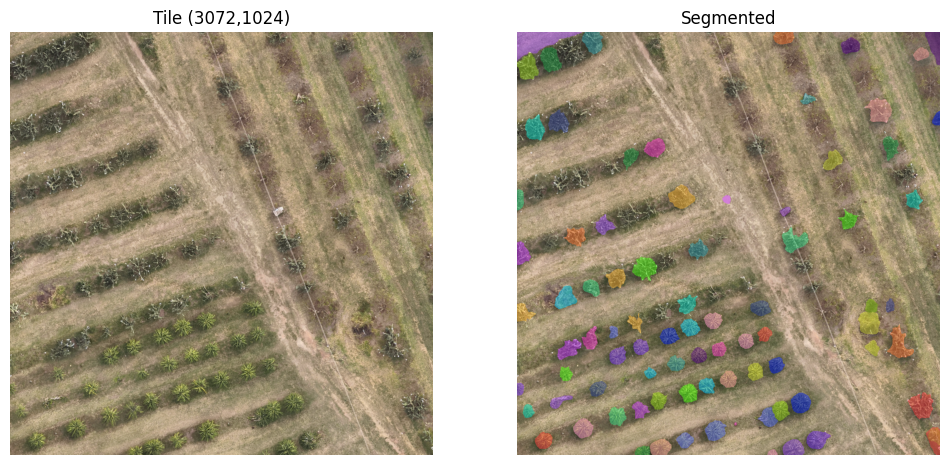

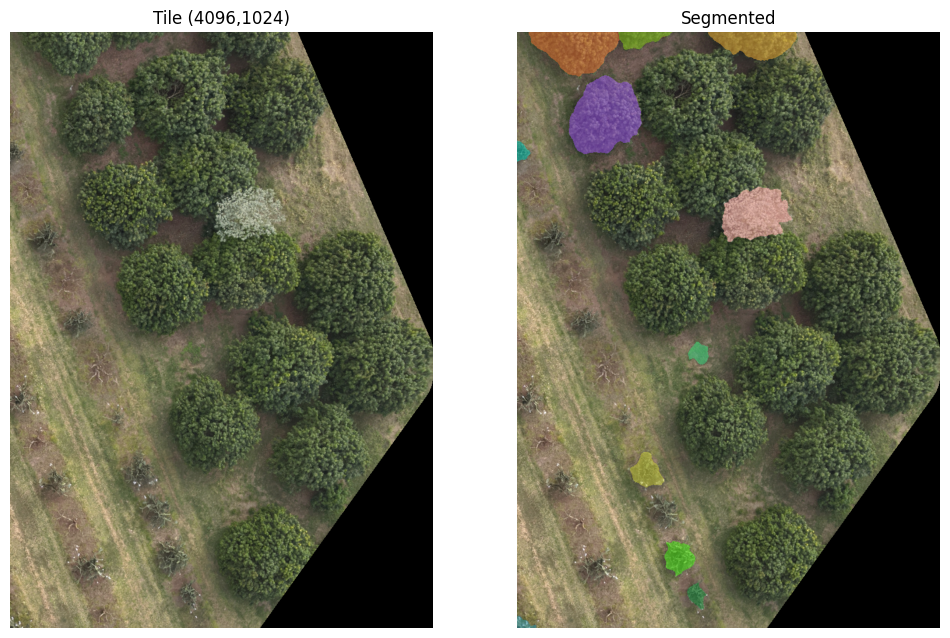

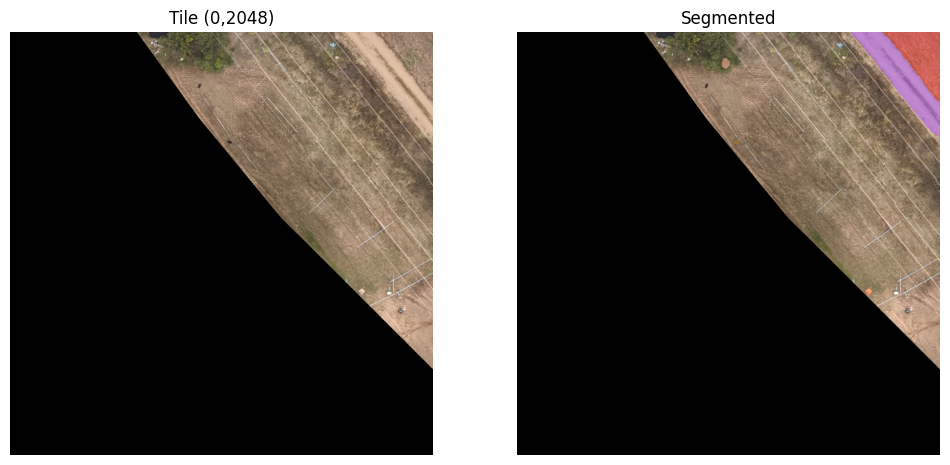

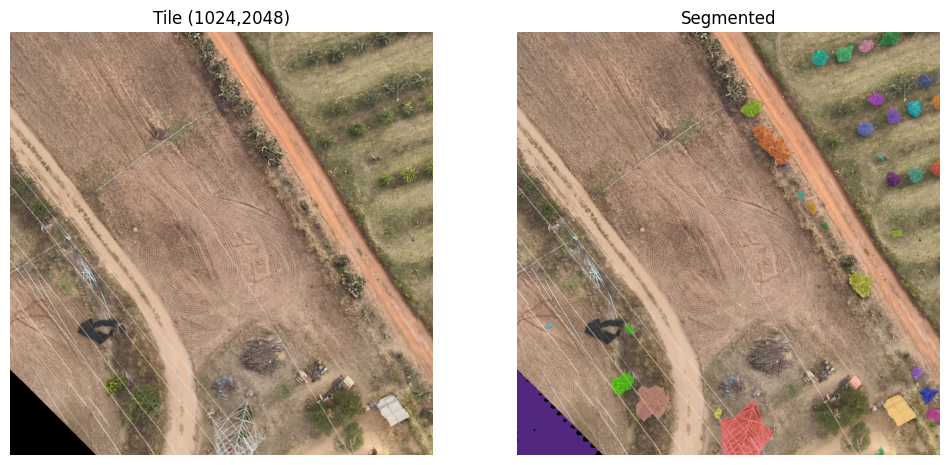

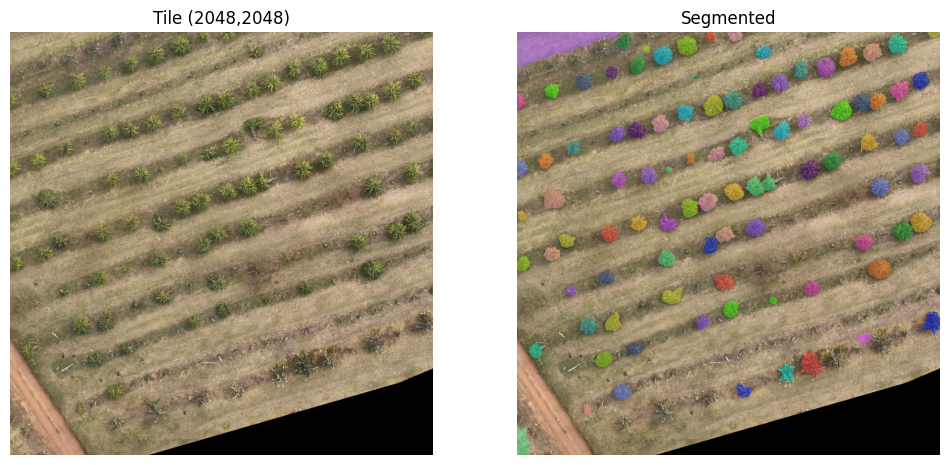

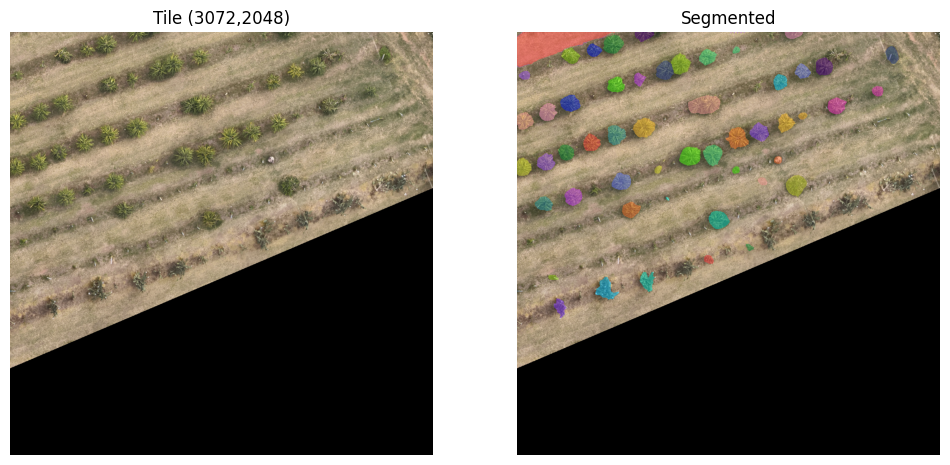

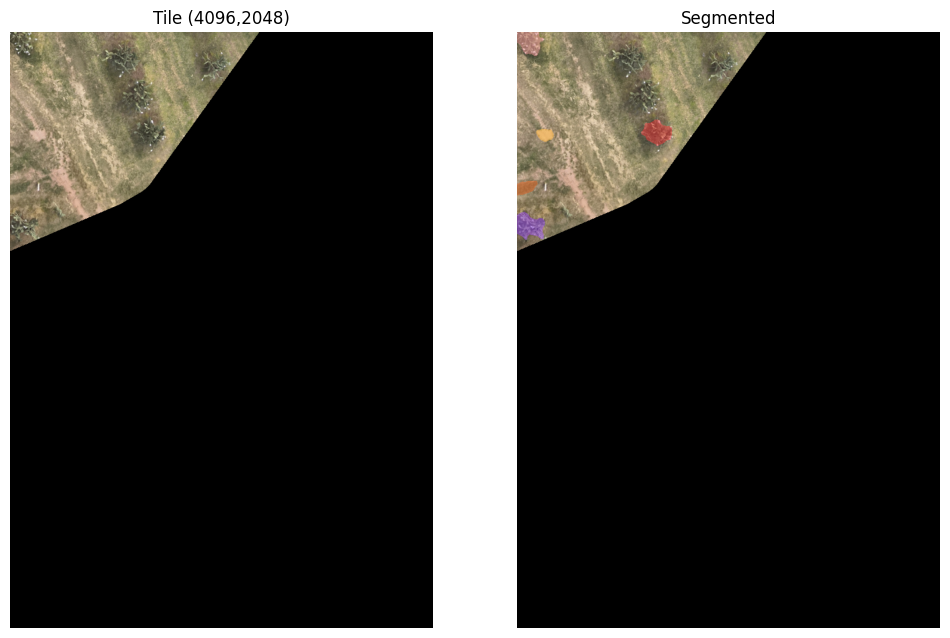

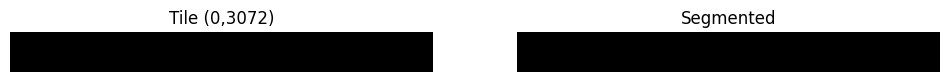

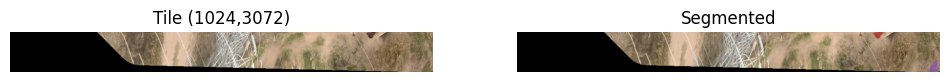

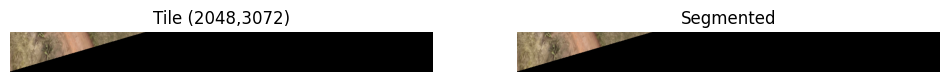

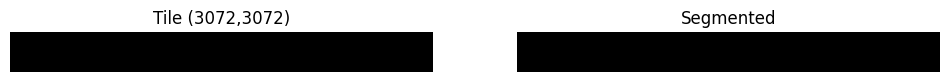

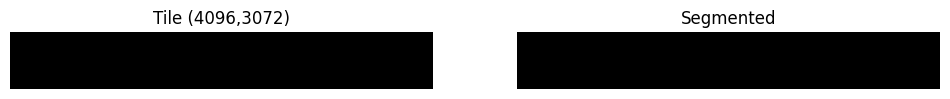

In [10]:
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

# === 1. Carregar imagem com OpenCV ===
image_bgr = cv2.imread(f"{HOME}/data/Task-of-2025-07-21T03.tif")
height, width, _ = image_bgr.shape

# === 3. Parâmetros do tile ===
tile_size = 1024
annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# === 4. Varredura por blocos ===
for y0 in range(0, height, tile_size):
    for x0 in range(0, width, tile_size):
        y1 = min(y0 + tile_size, height)
        x1 = min(x0 + tile_size, width)

        tile_bgr = image_bgr[y0:y1, x0:x1]
        if tile_bgr.shape[0] < 64 or tile_bgr.shape[1] < 64:
            continue  # pula blocos pequenos

        # === Aplicar SAM ===
        tile_rgb = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2RGB)
        sam_result = mask_generator.generate(tile_rgb)

        # Parâmetro ajustável: porcentagem máxima de ocupação da tile por uma máscara
        max_area_ratio = 0.02

        # === Filtrar sam_result ===
        filtered_masks = [
            m for m in sam_result
            if m["segmentation"].sum() / m["segmentation"].size < max_area_ratio
        ]

        # === Criar detections com máscaras filtradas ===
        detections = sv.Detections.from_sam(sam_result=filtered_masks)

        # === Anotar tile apenas com máscaras válidas ===
        annotated_tile = annotator.annotate(scene=tile_bgr.copy(), detections=detections)

        # === Mostrar comparação ===
        sv.plot_images_grid(
            images=[tile_bgr, annotated_tile],
            grid_size=(1, 2),
            titles=[f'Tile ({x0},{y0})', 'Segmented']
        )

In [11]:
from tqdm import tqdm
# === 3. Criar imagem de saída (anotada) ===
final_annotated = np.zeros_like(image_bgr)

# === 4. Loop por blocos ===
tile_size = 1024

for y0 in tqdm(range(0, height, tile_size), desc="Processando linhas"):
    for x0 in range(0, width, tile_size):
        y1 = min(y0 + tile_size, height)
        x1 = min(x0 + tile_size, width)

        tile_bgr = image_bgr[y0:y1, x0:x1]
        if tile_bgr.shape[0] < 64 or tile_bgr.shape[1] < 64:
            continue

        tile_rgb = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2RGB)
        sam_result = mask_generator.generate(tile_rgb)

        # === Criar detections com máscaras filtradas ===
        detections = sv.Detections.from_sam(sam_result=filtered_masks)


        annotated_tile = annotator.annotate(scene=tile_bgr.copy(), detections=detections)

        # Reposicionar tile segmentado na imagem final
        final_annotated[y0:y1, x0:x1] = annotated_tile

# === 5. Salvar imagem final ===
cv2.imwrite(f"{HOME}/data/imagem_segmentada_completa.png", final_annotated)
print("✅ Imagem final salva como 'imagem_segmentada_completa.png'")

Processando linhas: 100%|██████████| 4/4 [01:57<00:00, 29.42s/it]


✅ Imagem final salva como 'imagem_segmentada_completa.png'


# Calcular centroides das máscaras


In [12]:
centros_globais = []
# === 3. Criar imagem de saída (anotada) ===
final_annotated = np.zeros_like(image_bgr)

# === 4. Loop por blocos ===
tile_size = 1024

for y0 in tqdm(range(0, height, tile_size), desc="Processando linhas"):
    for x0 in range(0, width, tile_size):
        y1 = min(y0 + tile_size, height)
        x1 = min(x0 + tile_size, width)

        tile_bgr = image_bgr[y0:y1, x0:x1]
        if tile_bgr.shape[0] < 64 or tile_bgr.shape[1] < 64:
            continue

        tile_rgb = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2RGB)
        sam_result = mask_generator.generate(tile_rgb)


        # Parâmetro ajustável: porcentagem máxima de ocupação da tile por uma máscara
        max_area_ratio = 0.02

        # === Filtrar sam_result ===
        filtered_masks = [
            m for m in sam_result
            if m["segmentation"].sum() / m["segmentation"].size < max_area_ratio
        ]

        for m in filtered_masks:
          mask = m["segmentation"].astype(np.uint8)

          # Usar moments do OpenCV para calcular centroide local (dentro do tile)
          M = cv2.moments(mask)
          if M["m00"] == 0:
              continue  # evita divisão por zero

          cx_tile = int(M["m10"] / M["m00"])  # coluna local
          cy_tile = int(M["m01"] / M["m00"])  # linha local

          # Converter para coordenadas globais (na imagem original)
          cx_global = x0 + cx_tile
          cy_global = y0 + cy_tile

          centros_globais.append((cx_global, cy_global))

        # === Criar detections com máscaras filtradas ===
        detections = sv.Detections.from_sam(sam_result=filtered_masks)


        annotated_tile = annotator.annotate(scene=tile_bgr.copy(), detections=detections)

        # Reposicionar tile segmentado na imagem final
        final_annotated[y0:y1, x0:x1] = annotated_tile

# Copiar a imagem original para desenhar sobre ela
imagem_com_pontos = image_bgr.copy()

print(f"Centroides calculados: {len(centros_globais)}")

# Desenhar círculos vermelhos com raio 5 em cada centro
for (x, y) in centros_globais:
    cv2.circle(imagem_com_pontos, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

cv2.imwrite(f"{HOME}/data/imagem_com_centros.png", imagem_com_pontos)

Processando linhas: 100%|██████████| 4/4 [02:02<00:00, 30.50s/it]


Centroides calculados: 589


True

In [13]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import math

# 1. organiza pontos
pts = np.array(centros_globais)  # shape (N,2), col0=x, col1=y

# 2. encontra direção das fileiras via NN
nbrs = NearestNeighbors(n_neighbors=2).fit(pts)
_, idx = nbrs.kneighbors(pts)
neighbors = pts[idx[:,1]]  # pega o 2º vizinho (o 1º é o próprio ponto)

vectors = neighbors - pts
angles = np.arctan2(vectors[:,1], vectors[:,0])
# normaliza para [0, π)
angles = np.mod(angles, math.pi)

# histograma e pico
hist, bins = np.histogram(angles, bins=180, range=(0, math.pi))
theta = (bins[np.argmax(hist)] + bins[np.argmax(hist)+1]) / 2

# 3. rotaciona para alinhar horizontalmente
cos_t, sin_t = math.cos(-theta), math.sin(-theta)
R = np.array([[cos_t, -sin_t],
              [sin_t,  cos_t]])
pts_rot = pts.dot(R.T)

# 4. clusteriza pelas coordenadas y_rot
y_vals = pts_rot[:,1].reshape(-1,1)
# eps ajusta-se à distância inter-fileiras (em px)
db = DBSCAN(eps=20, min_samples=5).fit(y_vals)
labels = db.labels_

# 5. para cada fileira, calcula slope e intercept
slope = math.tan(theta)
linhas = []
for lbl in set(labels):
    if lbl < 0:
        continue  # ruído
    grp = pts[labels == lbl]
    xm, ym = grp.mean(axis=0)
    intercept = ym - slope * xm
    linhas.append((slope, intercept))

# linhas agora é uma lista de (m, b) para cada fileira: y = m·x + b
print(f"Detectei {len(linhas)} fileiras")
for i, (m, b) in enumerate(linhas):
    print(f"  Fileira {i+1}: y = {m:.4f}·x + {b:.1f}")


Detectei 22 fileiras
  Fileira 1: y = -0.3541·x + 1409.3
  Fileira 2: y = -0.3541·x + 1643.5
  Fileira 3: y = -0.3541·x + 1525.2
  Fileira 4: y = -0.3541·x + 1211.8
  Fileira 5: y = -0.3541·x + 1852.5
  Fileira 6: y = -0.3541·x + 2011.7
  Fileira 7: y = -0.3541·x + 1746.0
  Fileira 8: y = -0.3541·x + 2177.8
  Fileira 9: y = -0.3541·x + 2330.6
  Fileira 10: y = -0.3541·x + 2488.5
  Fileira 11: y = -0.3541·x + 2632.8
  Fileira 12: y = -0.3541·x + 2769.5
  Fileira 13: y = -0.3541·x + 2941.1
  Fileira 14: y = -0.3541·x + 3043.0
  Fileira 15: y = -0.3541·x + 3118.1
  Fileira 16: y = -0.3541·x + 3231.7
  Fileira 17: y = -0.3541·x + 3350.2
  Fileira 18: y = -0.3541·x + 3465.5
  Fileira 19: y = -0.3541·x + 3572.1
  Fileira 20: y = -0.3541·x + 3648.4
  Fileira 21: y = -0.3541·x + 3753.5
  Fileira 22: y = -0.3541·x + 3836.4


In [14]:
import csv

# Nome do arquivo de saída
nome_arquivo = f"{HOME}/data/fileiras.csv"

# Escreve os dados no CSV
with open(nome_arquivo, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Fileira', 'Slope (m)', 'Intercept (b)'])  # Cabeçalho
    for i, (m, b) in enumerate(linhas):
        writer.writerow([i + 1, m, b])

print(f'Arquivo "{nome_arquivo}" criado com sucesso.')

Arquivo "/content/data/fileiras.csv" criado com sucesso.


In [15]:
import csv

# Nome do arquivo de saída
nome_arquivo = f"{HOME}/data/centroides.csv"

# Escreve os dados no CSV
with open(nome_arquivo, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['x', 'y'])  # Cabeçalho
    for i, (m, b) in enumerate(centros_globais):
        writer.writerow([m, b])

print(f'Arquivo "{nome_arquivo}" criado com sucesso.')

Arquivo "/content/data/centroides.csv" criado com sucesso.


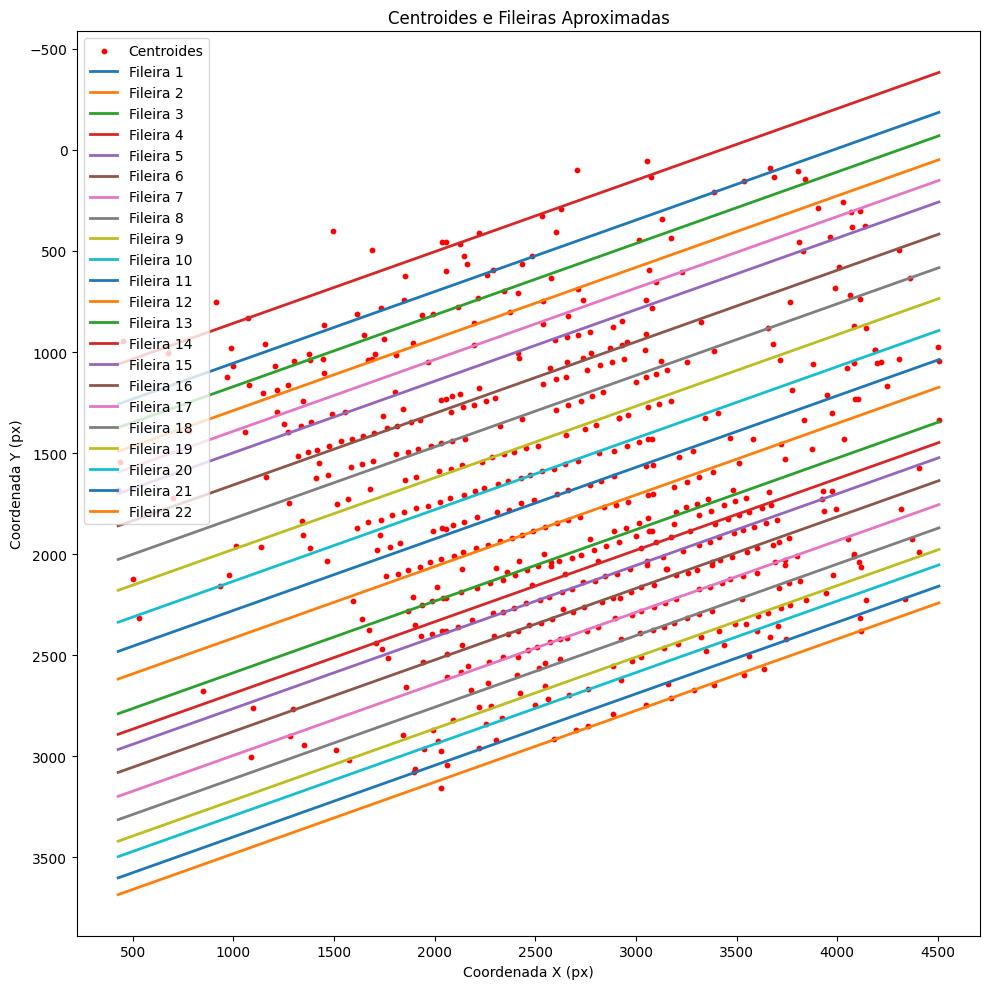

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- dados de exemplo (substitua pelos seus) ---
# centros_globais = [(x1, y1), (x2, y2), ...]
# linhas = [(m1, b1), (m2, b2), ...]

# Transforma em arrays para facilitar
pts = np.array(centros_globais)
x_vals = pts[:,0]
y_vals = pts[:,1]

# Cria figura
plt.figure(figsize=(10,10))

# 1) Plota os centroides como pontos vermelhos
plt.scatter(x_vals, y_vals, s=10, color='red', label='Centroides')

# 2) Para cada fileira, traça a reta no intervalo de x
x_min, x_max = x_vals.min(), x_vals.max()
x_line = np.linspace(x_min, x_max, 500)

for idx, (m, b) in enumerate(linhas, start=1):
    y_line = m * x_line + b
    plt.plot(x_line, y_line, linewidth=2, label=f'Fileira {idx}')

# 3) Ajustes de visualização
plt.legend()
plt.xlabel('Coordenada X (px)')
plt.ylabel('Coordenada Y (px)')
plt.title('Centroides e Fileiras Aproximadas')

# Se quiser manter a mesma orientação de imagem (origem no canto superior esquerdo):
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [17]:
import cv2
import numpy as np

# 1. Carrega a imagem original (BGR)
h, w = image_bgr.shape[:2]

# 2. Supondo que você já tenha:
#    centros_globais: lista de (x,y)
#    linhas:       lista de (m, b) para y = m*x + b

output = image_bgr.copy()

# 3. Desenha os centroides
for x, y in centros_globais:
    cv2.circle(output, (int(x), int(y)), radius=5, color=(0,0,255), thickness=-1)

# 4. Desenha cada reta, calculando dois pontos de interseção com as bordas
for m, b in linhas:
    pts = []
    # interseção com x=0
    y0 = b
    if 0 <= y0 <= h:
        pts.append((0, int(y0)))
    # interseção com x=w-1
    y1 = m*(w-1) + b
    if 0 <= y1 <= h:
        pts.append((w-1, int(y1)))
    # interseção com y=0 (se m != 0)
    if m != 0:
        x0 = -b/m
        if 0 <= x0 <= w:
            pts.append((int(x0), 0))
    # interseção com y=h-1
    if m != 0:
        x1 = (h-1 - b)/m
        if 0 <= x1 <= w:
            pts.append((int(x1), h-1))
    # Se temos pelo menos dois pontos válidos, desenha o segmento
    if len(pts) >= 2:
        cv2.line(output, pts[0], pts[1], color=(0,255,0), thickness=2)

# 5. Salva em disco
cv2.imwrite(f"{HOME}/data/imagem_com_centroides_e_fileiras.png", output)


True